# Load Forecasting using Recurrent Neural Network

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.preprocessing
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

from keras.layers import Dense,Dropout,SimpleRNN
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#choosing PJME_hourly.csv data for analysis
fpath='input/PJME_hourly.csv'

df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [3]:
#checking missing data
df.isna().sum()

PJME_MW    0
dtype: int64

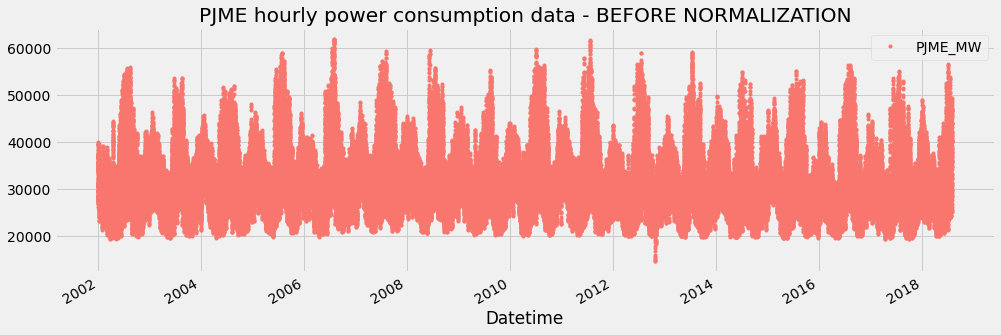

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

df.plot(style='.', figsize=(15,5), color=color_pal[0], legend=True)
plt.title('PJME hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [5]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(145366, 1)

In [6]:
co = 113927 #cutoff

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 31419 days are going to be used in test
    X_test = X_train[co:]             
    y_test = y_train[co:]
    
    #2 first 113927 days are going to be used in training
    X_train = X_train[:co]           
    y_train = y_train[:co]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (co, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [7]:
#create train, test data
seq_len = 24 # sequence length 

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape  = ', X_test.shape)
print('y_test.shape  = ',y_test.shape)

X_train.shape =  (113927, 24, 1)
y_train.shape =  (113927,)
X_test.shape  =  (31415, 24, 1)
y_test.shape  =  (31415,)


In [8]:
units = 24 #units
do = 0.5 #dropout

rnn_model = Sequential()

rnn_model.add(SimpleRNN(units,return_sequences=True, input_shape=(X_train.shape[1],1)))
#rnn_model.add(Dropout(do)) 

rnn_model.add(SimpleRNN(units,return_sequences=True))
#rnn_model.add(Dropout(do))

rnn_model.add(SimpleRNN(units,return_sequences=False))
#rnn_model.add(Dropout(do))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 24, 24)            624       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 24)            1176      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [9]:
epoch = 10 #epoch
batch_size = 1000 # nilia paremeter yang divariasikan = 10, 100, 1000, 10000, 100000

rnn_model.compile(optimizer='sgd',loss="MSE")
rnn_model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size)

Epoch 1/10
114/114 [==============================] - 4s 37ms/step - loss: 0.0211
Epoch 2/10
114/114 [==============================] - 4s 36ms/step - loss: 0.0074
Epoch 3/10
114/114 [==============================] - 4s 36ms/step - loss: 0.0056
Epoch 4/10
114/114 [==============================] - 4s 38ms/step - loss: 0.0038
Epoch 5/10
114/114 [==============================] - 5s 41ms/step - loss: 0.0026
Epoch 6/10
114/114 [==============================] - 5s 41ms/step - loss: 0.0022
Epoch 7/10
114/114 [==============================] - 5s 41ms/step - loss: 0.0020
Epoch 8/10
114/114 [==============================] - 5s 43ms/step - loss: 0.0018
Epoch 9/10
114/114 [==============================] - 5s 46ms/step - loss: 0.0017
Epoch 10/10
114/114 [==============================] - 5s 44ms/step - loss: 0.0016


In [10]:
rnn_predictions = rnn_model.predict(X_test)

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(y_true=y_test,
                   y_pred=rnn_predictions.transpose())
print('MAPE =', round(MAPE,2), '%')

MAPE = 8.9 %


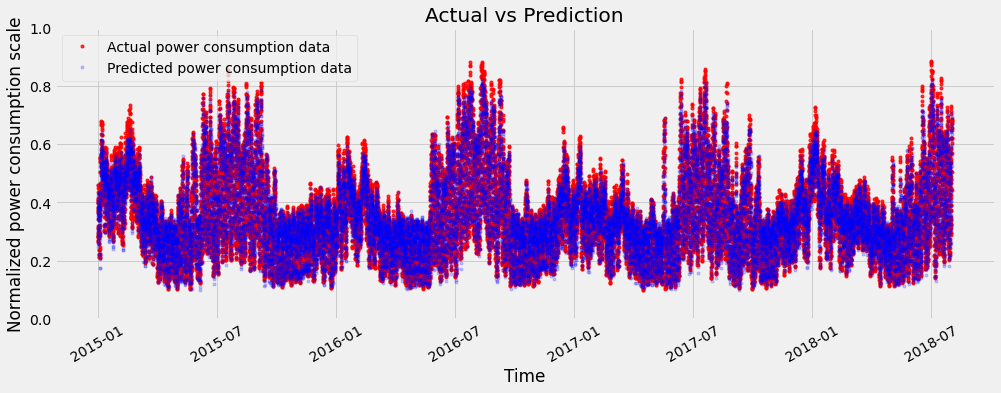

In [12]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(15,5))
    plt.plot(test, 'r.', alpha=0.8, label='Actual power consumption data')
    plt.plot(predicted[:,0], 'b.', alpha=0.2, label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    x_ticks = np.arange(0, 31419, 4380)
    plt.xticks(range(0, 31419, 4380),
               ['2015-01', '2015-07', '2016-01', '2016-07', '2017-01', '2017-07', '2018-01', '2018-07' ], rotation=30)
    plt.xticks(x_ticks)
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Actual vs Prediction")

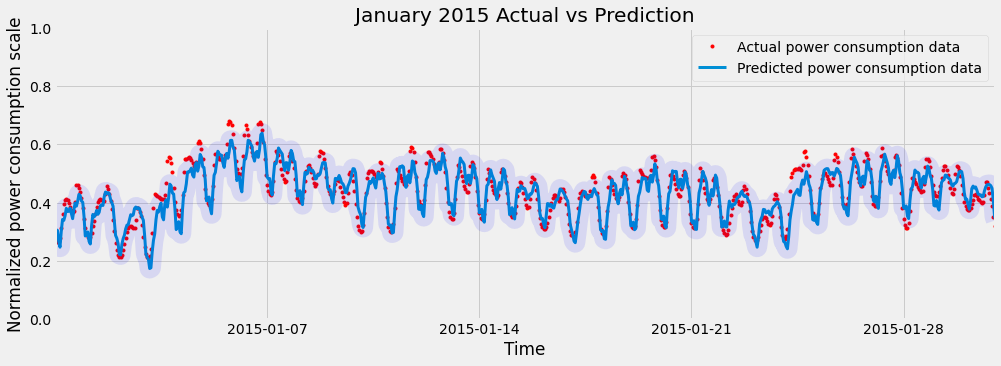

In [13]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(15,5))
    plt.plot(test, 'r.', linewidth=10, label='Actual power consumption data')
    plt.plot(predicted[:,0], linewidth= 3, label='Predicted power consumption data')
    plt.plot(predicted[:,0], color='b', linewidth= 20, alpha=0.1)
    plt.title(title)
    plt.xlim([0,744])
    plt.ylim([0,1])
    x_ticks = np.arange(0, 744, 168)
    plt.xticks(range(0, 744, 168),
               ['', '2015-01-07', '2015-01-14', '2015-01-21', '2015-01-28'])
    plt.xticks(x_ticks)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "January 2015 Actual vs Prediction")

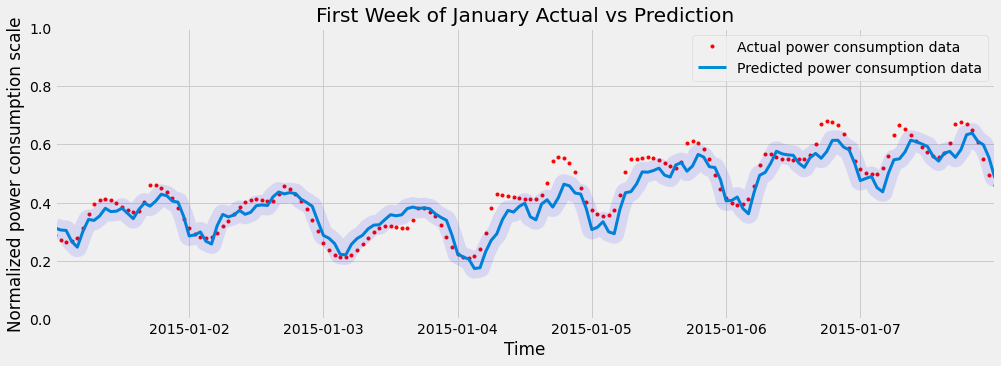

In [14]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(15,5))
    plt.plot(test, 'r.', linewidth=10, label='Actual power consumption data')
    plt.plot(predicted[:,0], linewidth= 3, label='Predicted power consumption data')
    plt.plot(predicted[:,0], color='b', linewidth= 20, alpha=0.1)
    plt.title(title)
    plt.xlim([0,168])
    plt.ylim([0,1])
    x_ticks = np.arange(0, 168, 24)
    plt.xticks(range(0, 168, 24),
               ['', '2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06', '2015-01-07'])
    plt.xticks(x_ticks)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "First Week of January Actual vs Prediction")

In [15]:
X_train

array([[[0.3339092 ],
        [0.31014432],
        [0.29101443],
        ...,
        [0.41004951],
        [0.36475298],
        [0.31642263]],

       [[0.31014432],
        [0.29101443],
        [0.28136522],
        ...,
        [0.36475298],
        [0.31642263],
        [0.28604235]],

       [[0.29101443],
        [0.28136522],
        [0.28469399],
        ...,
        [0.31642263],
        [0.28604235],
        [0.27163173]],

       ...,

       [[0.43783841],
        [0.40996524],
        [0.38466238],
        ...,
        [0.4348678 ],
        [0.42743074],
        [0.41626462]],

       [[0.40996524],
        [0.38466238],
        [0.36032866],
        ...,
        [0.42743074],
        [0.41626462],
        [0.39361635]],

       [[0.38466238],
        [0.36032866],
        [0.34153587],
        ...,
        [0.41626462],
        [0.39361635],
        [0.35638892]]])